In [ ]:
%pip install pandas
%pip install matplotlib
%pip install opencv-python
%pip install scipy

In [31]:
%pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp39-cp39-win_amd64.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    -----------

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2

data_dir = 'C:/Users/user/OneDrive/Masaüstü/fer2013' #path of dataset
train_dir = os.path.join(data_dir, "train") #we obtain => data_dir/train (train dir under the fer2013 dir)
test_dir = os.path.join(data_dir, "test") #we obtain => data_dir/test  path

first_3_images = {} 

# iterate over each category
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category) #we obtain path for each category (ex = .../train/surprise)
    if os.path.isdir(category_path):  # check if it is a dir or not
        images = sorted(os.listdir(category_path))[:3]  # take the first 3 images
        first_3_images[category] = [os.path.join(category_path, img) for img in images] #path for each img in categories

# print the result
for category, images in first_3_images.items():
    print(f"Category: {category}")
    for img in images:
        print(f"  {img}")


In [ ]:
# visualize the first 3 images for each category, side by side
for category, images in first_3_images.items():
    print(f"Displaying 3 images for category: {category}")
    
    # set up a grid for 3 images side by side
    plt.figure(figsize=(12, 4))  # adjust size as needed
    for i, img_path in enumerate(images):
        img = Image.open(img_path)  # open the image
        plt.subplot(1, 3, i + 1)  # create a subplot (1 row, 3 columns)
        plt.imshow(img)  # if you want to display image in grayscale use cmap="gray
        plt.title(category, fontsize=12)  # add title for each image
        plt.axis("off")  # hide axes for clarity
    
    plt.tight_layout()
    plt.show() 

In [5]:
# see how many images we have for each category
categories = os.listdir(train_dir) 
for category in categories:
    category_path = os.path.join(train_dir, category)
    num_images = len(os.listdir(category_path))
    print(f"Category '{category}' has {num_images} images.")

Category 'angry' has 3995 images.
Category 'disgust' has 436 images.
Category 'fear' has 4097 images.
Category 'happy' has 7215 images.
Category 'neutral' has 4965 images.
Category 'sad' has 4830 images.
Category 'surprise' has 3171 images.


In [6]:

def load_images_from_folder(folder_path):
    images = []
    labels = []
    categories = os.listdir(folder_path)
    
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    
    for label, category in enumerate(categories):
        category_path = os.path.join(folder_path, category)
        if not os.path.isdir(category_path): # check if it is a dir or not
            print(f"Skipping non-directory: {category_path}")
            continue
        
        for img_name in os.listdir(category_path):
            if not img_name.lower().endswith(valid_extensions): # check if img format is valid or not
                print(f"Skipping unsupported file: {img_name}")
                continue
            
            img_path = os.path.join(category_path, img_name)
            img_path = img_path.replace("\\", "/")  # converting all back slashes to normal slash
            
            try:
                # open the img with pillow (cv2.imread() throws an error so I used pil)
                pil_img = Image.open(img_path).convert('L')  # 'L' is grayscale format
                # resize the images
                pil_img = pil_img.resize((48, 48))
                
                # convert img to np array
                img = np.array(pil_img)
                
                # push img and its label
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

In [7]:
train_labels[0] #check the result

0

In [8]:
train_images = train_images / 255.0  # normalize to range [0, 1]
test_images = test_images / 255.0

In [9]:
from tensorflow.keras.utils import to_categorical
#one-hot encoding
num_classes = len(categories)
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [10]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(train_images.reshape(-1, 48, 48, 1))  # images should be 4 dimensionals: (num_samples, height, width, channels)

In [ ]:
# print the first 5 training images
for i in range(5):
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"Label: {np.argmax(train_labels[i])}")
    plt.axis("off")
    plt.show()

In [12]:
train_images = train_images.reshape(-1, 48, 48, 1)
test_images = test_images.reshape(-1, 48, 48, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_labels.shape[1], activation='softmax')  # train_label.shape[1] => number of classes
])

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
batch_size = 32
epochs = 20  # number of epoch

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    validation_data=(test_images, test_labels),
    epochs=epochs
)

In [19]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}") # print the accuracy of test

225/225 - 1s - 5ms/step - accuracy: 0.5208 - loss: 1.2604
Test accuracy: 0.5207578539848328


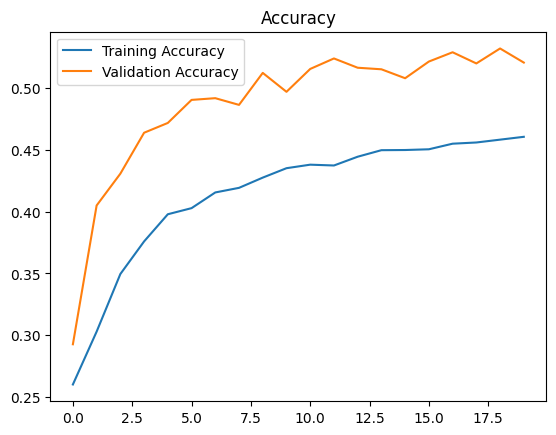

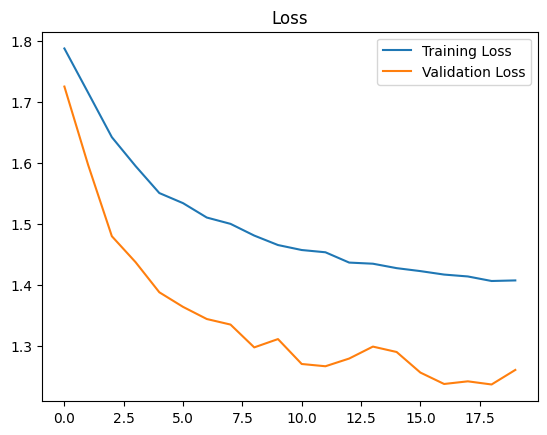

In [20]:
import matplotlib.pyplot as plt

#visualize the accuracy and loss

# accuracy of training and validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# loss of training and validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [21]:
# predict class probabilities
y_pred_prob = model.predict(test_images)

# convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels, axis=1)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


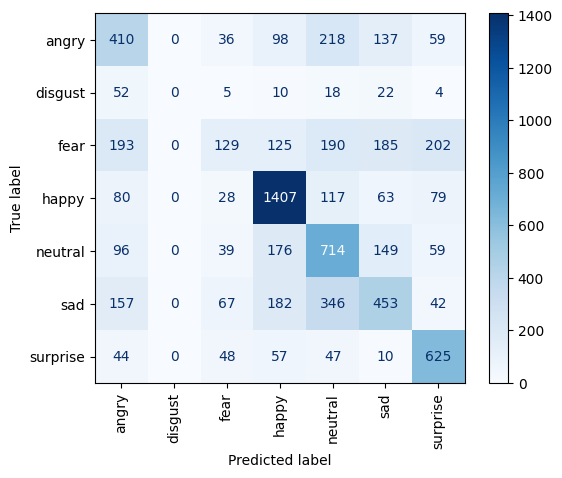

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# cisplay confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)  # using class names
disp.plot(cmap='Blues', xticks_rotation='vertical')


In [ ]:
# model should be updated
# result is not satisfying